In [1]:
# import 
import numpy as np
import random
from proglearn.sims import generate_gaussian_parity
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
import sklearn.ensemble
from sklearn import metrics 
import math
from scipy.stats import ttest_ind
from scipy.spatial import distance
import random

In [2]:
# number of samples
n_samples = 100

# generate xor 
X_xor, y_xor = generate_gaussian_parity(n_samples, angle_params=0)

# generate rxor, 45 degrees
X_rxor, y_rxor = generate_gaussian_parity(n_samples, angle_params=np.pi/4)

In [3]:
# xor rf
clf_xor = sklearn.ensemble.RandomForestClassifier(n_estimators=1, min_samples_leaf=int(n_samples/7))

# rxor rf
clf_rxor = sklearn.ensemble.RandomForestClassifier(n_estimators=1, min_samples_leaf=int(n_samples/7))

In [4]:
# fit the model using the train data 
clf_xor.fit(X_xor, y_xor)

# fit rxor model
clf_rxor.fit(X_rxor, y_rxor)

RandomForestClassifier(min_samples_leaf=14, n_estimators=1)

In [5]:
# index of each array that each sample ends up in
xor_leaves_xor_rf = clf_xor.apply(X_xor)
rxor_leaves_xor_rf = clf_xor.apply(X_rxor)

# repeat for rxor rf
xor_leaves_rxor_rf = clf_rxor.apply(X_xor)
rxor_leaves_rxor_rf = clf_rxor.apply(X_rxor)

In [6]:
# function get % of samples at each label for each polytope (xor or rxor)
def percentLabels(leaves, true_labels):
    # dict to hold the %'s 
    # polytope as key, value = [% samples at this polytope with label 0, % samples at this polytope with label 1]
    perc_labels_at_poly = {}
    
    for uni in np.unique(leaves):
        # idx of each unique polytope 
        poly_to_test = np.where(leaves == uni)[0]
        num_0 = 0
        num_1 = 0

        # sum the number of each label at each poly/leaf
        for i in poly_to_test:
            if true_labels[i] == 0: 
                num_0+=1
            else:
                num_1+=1

        # calc % of each label at each polytope/leaf
        total_samples_at_poly = num_0 + num_1
        perc_0 = num_0 / total_samples_at_poly
        perc_1 = num_1 / total_samples_at_poly

        perc_labels_at_poly[uni] = [perc_0, perc_1]
        
    return perc_labels_at_poly

In [7]:
# get % of samples in each label for each polytope for xor rf
perc_labels_at_poly_xor_xor_rf = percentLabels(xor_leaves_xor_rf, y_xor)
perc_labels_at_poly_rxor_xor_rf = percentLabels(rxor_leaves_xor_rf, y_rxor)

# repeat for rxor rf
perc_labels_at_poly_xor_rxor_rf = percentLabels(xor_leaves_rxor_rf, y_xor)
perc_labels_at_poly_rxor_rxor_rf = percentLabels(rxor_leaves_rxor_rf, y_rxor)

In [8]:
# calc l2 distance using the first percent for each polytope xor vs rxor 
def calcL2(xor_poly_percs, rxor_poly_percs):
    xor_label0_percs = []
    rxor_label0_percs = []
    
    # get each label 0 percent into a list for l2 calculation
    for key in xor_poly_percs.keys():
        xor_label0_percs.append(xor_poly_percs[key][0])
        rxor_label0_percs.append(rxor_poly_percs[key][0])
        
    
    return distance.euclidean(xor_label0_percs, rxor_label0_percs)

In [9]:
# calc l2's
xor_rf_l2 = calcL2(perc_labels_at_poly_xor_xor_rf, perc_labels_at_poly_rxor_xor_rf)
rxor_rf_l2 = calcL2(perc_labels_at_poly_xor_rxor_rf, perc_labels_at_poly_rxor_rxor_rf)

In [10]:
print('l2 distance between xor and rxor with xor rf:', xor_rf_l2)
print('l2 distance between xor and rxor with rxor rf', rxor_rf_l2)

l2 distance between xor and rxor with xor rf: 0.5054018106630361
l2 distance between xor and rxor with rxor rf 0.9438654010220847


In [11]:
# take average of these 2 distances 
d1 =  (xor_rf_l2 + rxor_rf_l2) / 2 
d1

0.7246336058425604

In [12]:
# conat xor and rxor class = 0 samples and class = 1 samples in different arrays
X_all_0 = np.concatenate((X_xor[np.where(y_xor == 0)], X_rxor[np.where(y_rxor == 0)]))
X_all_1 = np.concatenate((X_xor[np.where(y_xor == 1)], X_rxor[np.where(y_rxor == 1)]))

In [13]:
def getPval(X_all_0, X_all_1, d1):
    d1_greater_count = 0
    for i in range(0, 100000):
        # randomly sample 50 from class 0 and class 1 and call it xor, repeat for rxor
        this_xor = np.concatenate((random.sample(list(X_all_0), 50), random.sample(list(X_all_1), 50)))
        this_rxor = np.concatenate((random.sample(list(X_all_0), 50), random.sample(list(X_all_1), 50)))

        # we know that idx 0-49 is class 0 and 50-99 is class 1 for both
        labels = np.concatenate((np.zeros(50), np.ones(50)))

        # refit both models
        # fit xor
        clf_xor.fit(this_xor, labels)
        # fit rxor model
        clf_rxor.fit(this_rxor, labels)

        # push our xor and rxor to poly's (xor tree)
        this_xor_leaves = clf_xor.apply(this_xor)
        this_rxor_leaves = clf_xor.apply(this_rxor)

        # repeat for rxor tree
        this_xor_leaves_rxor_rf = clf_rxor.apply(this_xor)
        this_rxor_leaves_rxor_rf = clf_rxor.apply(this_rxor)

        # calc %'s at polys xor rf
        xor_perc = percentLabels(this_xor_leaves, labels)
        rxor_perc = percentLabels(this_rxor_leaves, labels)

        # repeat for rxor rf
        xor_perc_rxor_rf = percentLabels(this_xor_leaves_rxor_rf, labels)
        rxor_perc_rxor_rf = percentLabels(this_rxor_leaves_rxor_rf, labels)

        # calc l2 
        this_l2_xor_rf = calcL2(xor_perc, rxor_perc)
        this_l2_rxor_rf = calcL2(xor_perc_rxor_rf, rxor_perc_rxor_rf)

        if d1 > ((this_l2_xor_rf + this_l2_rxor_rf)/2): d1_greater_count+=1
        
    return (1 - (d1_greater_count/100000))

In [14]:
angle_sweep = range(0, 90, 5)
p_vals = []

for angle in angle_sweep:
    print('Processing angle:', angle)
    # we can use the same xor as from above but we need a new rxor 
    # generate rxor with different angles
    X_rxor, y_rxor = generate_gaussian_parity(n_samples, angle_params=math.radians(angle))
    
    # recalc d1 for each angle
    # refit both models
    # fit xor
    clf_xor.fit(X_xor, y_xor)
    # fit rxor model
    clf_rxor.fit(X_rxor, y_rxor)
    
    # index of each array that each sample ends up in
    xor_leaves_xor_rf = clf_xor.apply(X_xor)
    rxor_leaves_xor_rf = clf_xor.apply(X_rxor)

    # repeat for rxor rf
    xor_leaves_rxor_rf = clf_rxor.apply(X_xor)
    rxor_leaves_rxor_rf = clf_rxor.apply(X_rxor)
    
    # get % of samples in each label for each polytope for xor rf
    perc_labels_at_poly_xor_xor_rf = percentLabels(xor_leaves_xor_rf, y_xor)
    perc_labels_at_poly_rxor_xor_rf = percentLabels(rxor_leaves_xor_rf, y_rxor)

    # repeat for rxor rf
    perc_labels_at_poly_xor_rxor_rf = percentLabels(xor_leaves_rxor_rf, y_xor)
    perc_labels_at_poly_rxor_rxor_rf = percentLabels(rxor_leaves_rxor_rf, y_rxor)
    
    # calc l2's
    xor_rf_l2 = calcL2(perc_labels_at_poly_xor_xor_rf, perc_labels_at_poly_rxor_xor_rf)
    rxor_rf_l2 = calcL2(perc_labels_at_poly_xor_rxor_rf, perc_labels_at_poly_rxor_rxor_rf)
    
    
    # take average of these 2 distances 
    # now we have a new d1 for each angle
    d1 =  (xor_rf_l2 + rxor_rf_l2) / 2 
    
    # conat xor and rxor class = 0 samples and class = 1 samples in different arrays
    X_all_0 = np.concatenate((X_xor[np.where(y_xor == 0)], X_rxor[np.where(y_rxor == 0)]))
    X_all_1 = np.concatenate((X_xor[np.where(y_xor == 1)], X_rxor[np.where(y_rxor == 1)]))
    
    # append the pval
    p_vals.append(getPval(X_all_0, X_all_1, d1))

Processing angle: 0
Processing angle: 5
Processing angle: 10
Processing angle: 15
Processing angle: 20
Processing angle: 25
Processing angle: 30
Processing angle: 35
Processing angle: 40
Processing angle: 45
Processing angle: 50
Processing angle: 55
Processing angle: 60
Processing angle: 65
Processing angle: 70
Processing angle: 75
Processing angle: 80
Processing angle: 85


In [15]:
p_vals

[0.009709999999999996,
 2.999999999997449e-05,
 0.0047599999999999865,
 0.0,
 2.0000000000020002e-05,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

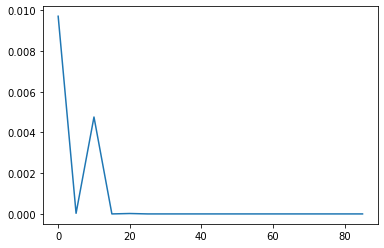

In [16]:
plt.plot(angle_sweep, p_vals)